Import what we need and possibly change the name of the host we need to access the database at. After this runs we have a fully bound database model.

In [1]:
from models import *
from epmt_job import setup_orm_db
import settings
settings.db_params["host"] = "db"
setup_orm_db()


List all the jobs in the database, lets print the ones longer than 2.5 hrs

In [2]:
js = Job.select()
print(len(js[:]),"jobs found")
for j in js:
    print("\t",j.jobname)

hrs_in_us = 1000000*60*60
print("\nFirst jobs longer than 2.5 hours")
j = select(j for j in Job if "atmos_0" in j.jobname and j.duration >= 2.5*hrs_in_us).first()
print("\t",j.jobname,j.duration/(1000000.0*60.0*60.0),"at",j.start,"by",j.user.name)
print("\t had",len(j.processes),"and",len(j.processes.threads),"threads")
jlong = j.jobid

16 jobs found
	 CM4_piControl_C_atmos_00050101
	 CM4_piControl_C_atmos_00100101
	 CM4_piControl_C_atmos_00150101
	 CM4_piControl_C_atmos_00200101
	 CM4_piControl_C_atmos_00250101
	 CM4_piControl_C_atmos_level_00050101
	 CM4_piControl_C_atmos_level_00100101
	 CM4_piControl_C_atmos_level_00150101
	 CM4_piControl_C_atmos_level_00200101
	 CM4_piControl_C_atmos_level_00250101
	 CM4_piControl_C_atmos_level_cmip_00050101
	 CM4_piControl_C_atmos_level_cmip_00100101
	 CM4_piControl_C_atmos_level_cmip_00150101
	 CM4_piControl_C_atmos_level_cmip_00200101
	 CM4_piControl_C_atmos_level_cmip_00250101
	 1

First jobs longer than 2.5 hours
	 CM4_piControl_C_atmos_00150101 2.5814415716666668 at 2019-02-21 08:22:11.444810 by Jeffrey.Durachta
	 had 37464 and 42314 threads


Lets look at the executables in that run using Pandas and histogram. First we must import the prerequisites.

In [6]:
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = [15, 8]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Lets look at the number of executions of each executable present in this job.

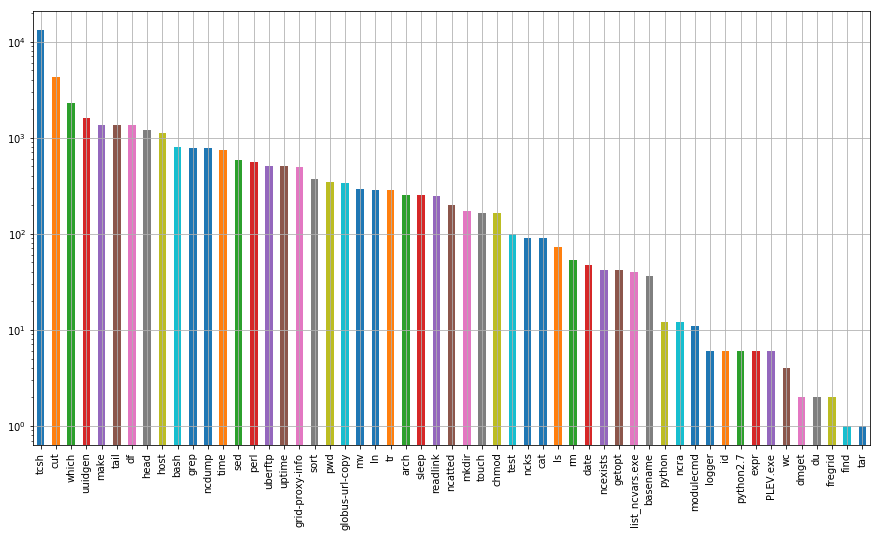

In [7]:
def plot_logy_histogram(series):
    series.plot.bar(grid=True)
    plt.yscale('log')

exename_list = list(j.processes.exename)
series = pd.Series(exename_list).value_counts()
plot_logy_histogram(series)




Plot the distribution of real time instead of frequency, requires a bit of trickery to get log scale with a histogram.

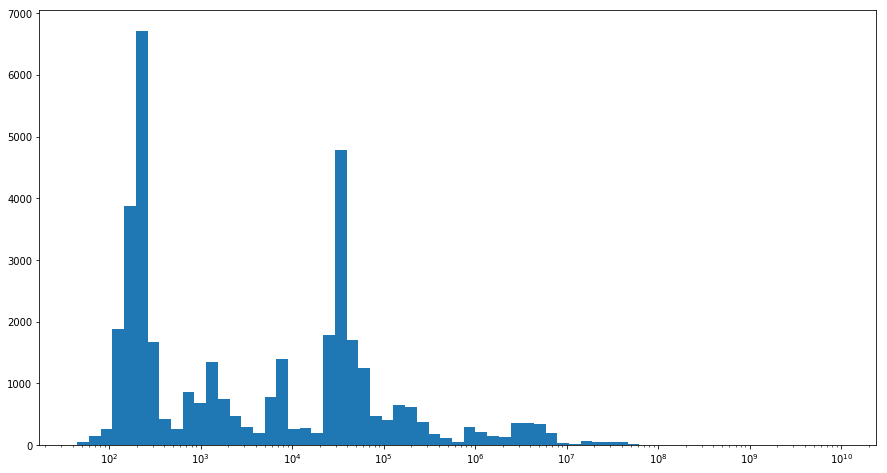

In [92]:
def plot_logx_histogram(data):
    _, bins = np.histogram(np.log10(data + 1), bins='auto')
    plt.hist(data, bins=10**bins);
    plt.gca().set_xscale("log")


processes = []
starttimes = []
durations = []
exenames = []

for p in j.processes:
    processes.append(p)
    starttimes.append(p.start)
    durations.append(p.duration)
    exenames.append(p.exename)

df = pd.DataFrame({'exename':exenames, 'duration':durations, 'start':starttimes, 'process':processes})
#print(Process[79960].exename,Process[79960].duration,Process[79960].start)
#print(Process[95018].exename,Process[95018].duration,Process[95018].start)

series = pd.Series(durations)
plot_logx_histogram(series)





What about just those that ran longer than 10 seconds? Lets also add the start time.

284 processes ran longer than 10s
time               92
perl               90
bash               21
globus-url-copy    21
uberftp            21
tcsh               19
make               18
fregrid             2
Name: exename, dtype: int64


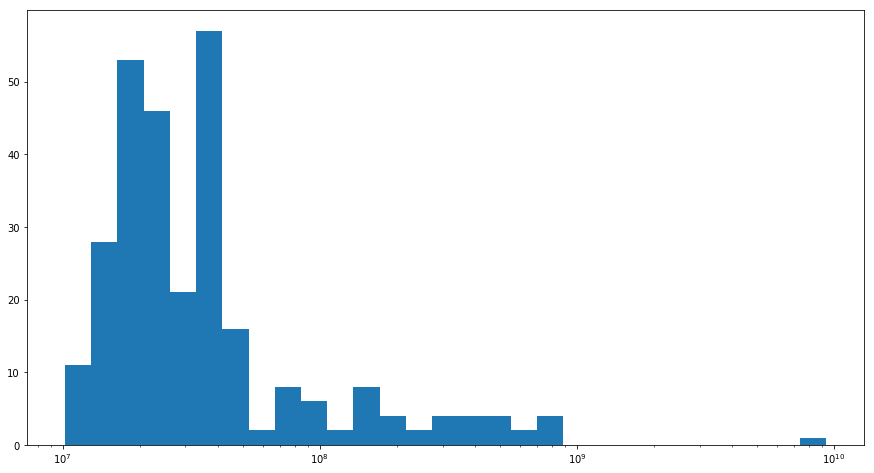

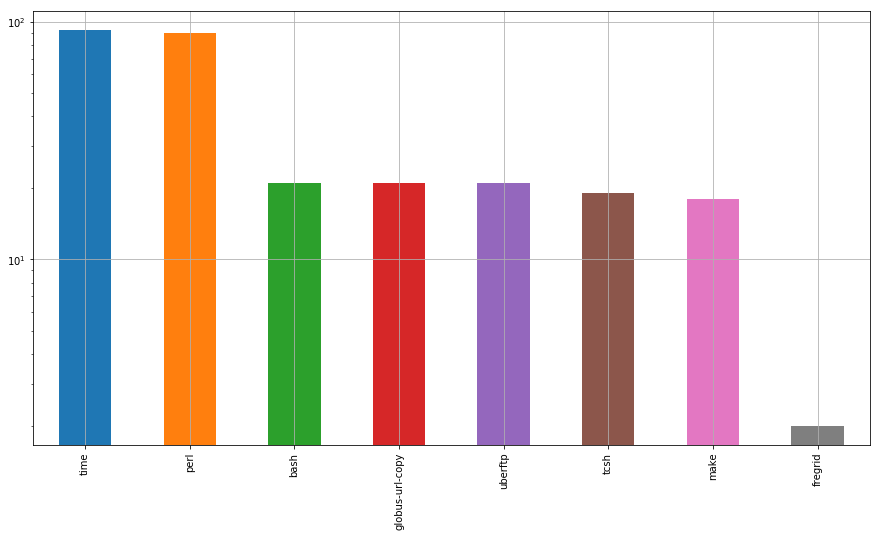

In [95]:

newdf = df[df.duration > 10000000].copy()
print(len(newdf),"processes ran longer than 10s")
print(newdf.exename.value_counts())
plot_logx_histogram(newdf.duration)
plt.show()
plot_logy_histogram(newdf.exename.value_counts())



Lets plot the sum contributions of the executables in this range

exename
bash               4.723779e+08
fregrid            2.987324e+08
globus-url-copy    4.490358e+08
make               4.443542e+08
perl               8.229228e+09
tcsh               9.729624e+09
time               8.532000e+09
uberftp            4.819701e+08
Name: duration, dtype: float64


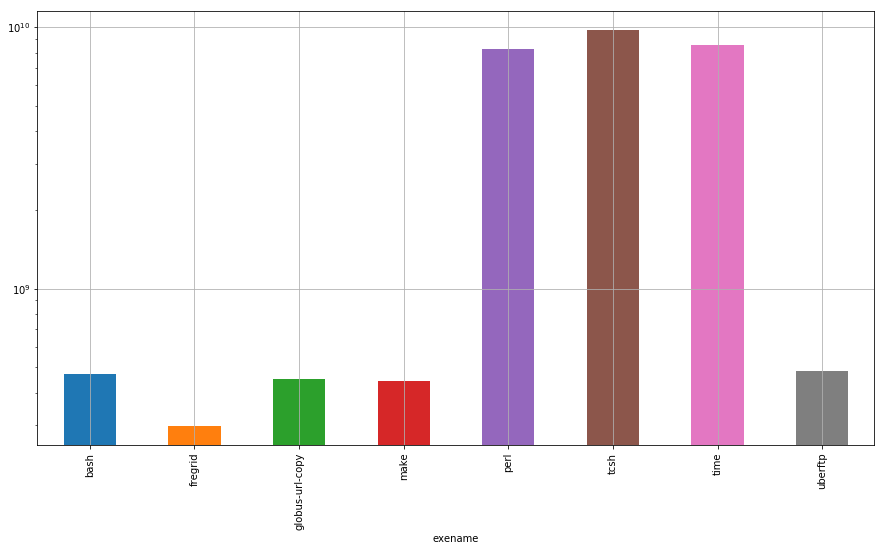

In [96]:
#print(newdf.groupby(['exename'])["duration"].describe())
print(newdf.groupby(['exename'])["duration"].agg("sum"))
newdf.groupby(['exename'])["duration"].agg("sum").plot.bar(grid=True)
plt.gca().set_yscale("log")


Let's examine the duration of the perl executable as this takes a lot of time.

90 runs of perl


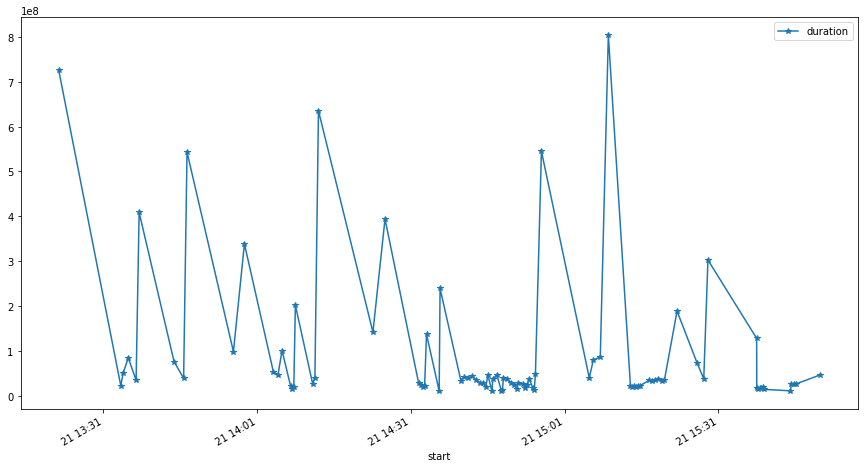

In [112]:
cutonly = newdf[newdf['exename'] == 'perl']
print(len(cutonly),"runs of perl")
cutonly
cutonly.sort_values(by=["start"]).plot(x='start', y='duration', style="-*")

#.plot()
#plot_logy_histogram(cutonly.duration)
#cutonly
#plot_logx_histogram(cutonly.duration)
#cutonly[cutonly.duration > 1000000000]

Here we  dig into the binary and find out what's happening.

In [142]:
BAD=cutonly[cutonly.duration > 700000000].process
print(BAD)

def get_process_metrics(po):
    meas = {}
    for m in po.threads.metrics:        
        if m.metricname.name not in meas:
            meas[m.metricname.name] = [ (m.value, m.thread) ]
        else:
            meas[m.metricname.name].append( (m.value, m.thread) )
# make df
    df = pd.DataFrame()
    for k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t
    return df

for p in BAD:
    pdf = get_process_metrics(p)
    print(pdf)
#    print(p.exename,p.duration,p.start,p.args)
#    for m in p.threads.metrics:
#        print(m.metricname.name,m.value)
    print()
#p = Process[102908]
#print(p.job.jobid == jlong)
#print(p.duration,p.exename)


32673    Process[88400]
37111    Process[87419]
Name: process, dtype: object
     wchar         thread  outblock  minflt  PERF_COUNT_SW_CPU_CLOCK  \
0  19355.0  Thread[99880]     240.0  5118.0              687553198.0   

   usertime   rssmax  processor  vol_ctxsw  rdtsc_duration      ...       \
0  110983.0  10260.0        4.0    32516.0    2.513769e+12      ...        

    time_oncpu  write_bytes  majflt  syscr  systemtime  num_threads  \
0  910134245.0     122880.0     1.0  254.0    798878.0          1.0   

   time_waiting  delayacct_blkio_time  guest_time     starttime  
0    21696702.0               20000.0         0.0  1.976338e+12  

[1 rows x 27 columns]
perl 726977548.0 2019-02-21 13:22:16.692514 /home/fms/local/opt/hsm/1.2.2/bin/hsmget -v -t -a /archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/history -p /ptmp/Jeffrey.Durachta/archive/Jeffrey.Durachta/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openm

Now define some helper functions. 

In [14]:
def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()

These are helper functions for queries. There are much much easier ways of doing this. But this suffices for now.

In [15]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print("not found",e)
        return None
    print("Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads")
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in list(proc_dict):
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

List all the jobs and whether they are a Post Processing Run

In [16]:
# All this does is select(j for j in Job)[:]

js = get_job_list() 
for j in js:
    print(j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s.")
    if j.ppr:
        print("\t","Post-processing run, job.name:",j.jobname)
        print("\t","Post-processing run, ppr.component:",j.ppr.component)
        print("\t","Post-processing run, ppr.name:",j.ppr.name)
        print("\t","Post-processing run, ppr.jobname:",j.ppr.jobname)
        print("\t","Post-processing run, ppr.oname:",j.ppr.oname)


20345339.moab01.princeton.rdhpcs.noaa.gov from 2019-02-20 19:58:41.274267 to 2019-02-20 22:13:23.131187 by Jeffrey.Durachta took 8081.85692 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00050101
	 Post-processing run, ppr.oname: 00050101
20348693.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 04:41:56.433031 to 2019-02-21 06:55:04.301253 by Jeffrey.Durachta took 7987.868222 s.
	 Post-processing run, job.name: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.component: atmos
	 Post-processing run, ppr.name: CM4_piControl_C
	 Post-processing run, ppr.jobname: CM4_piControl_C_atmos_00100101
	 Post-processing run, ppr.oname: 00100101
20349536.moab01.princeton.rdhpcs.noaa.gov from 2019-02-21 08:22:11.444810 to 2019-02-21 10:57:04.634468 by Jeffrey.Durachta took 9293.189658 s.
	 Post-processing run, job.name: CM

Lets just grab the first job here and plot some of its attributes

Found job 20345339.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


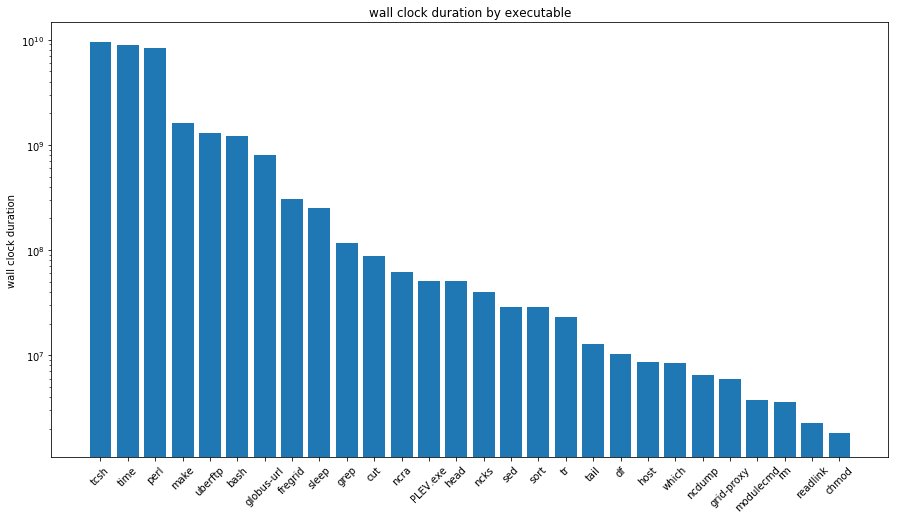

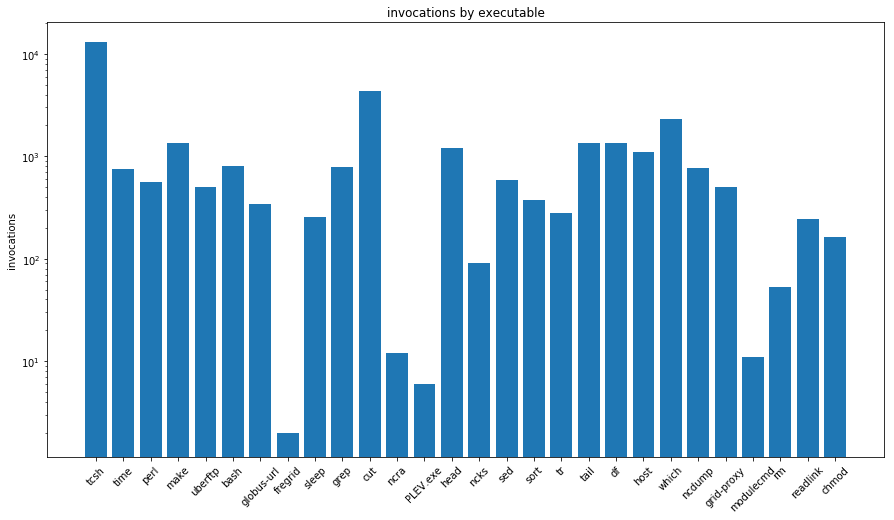

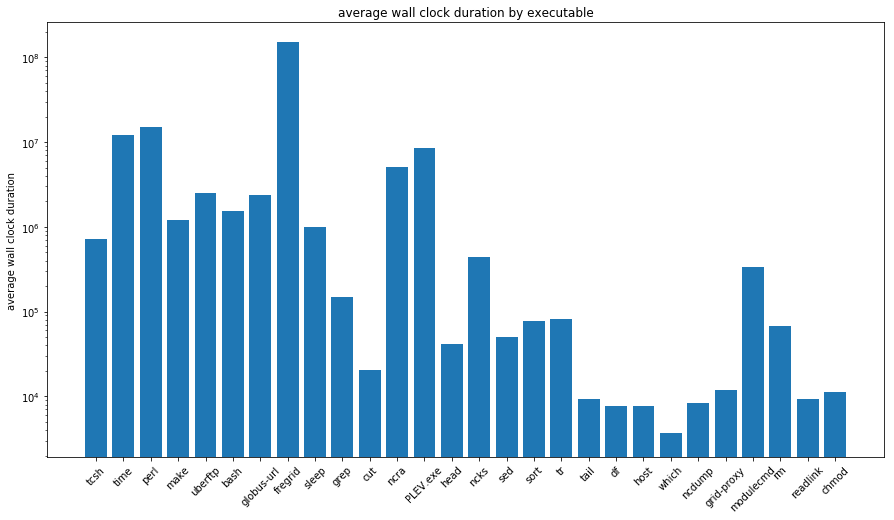

In [17]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



Here's an example function that filters for an executables prefix

In [181]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

Lets scatter plot this job and the long job

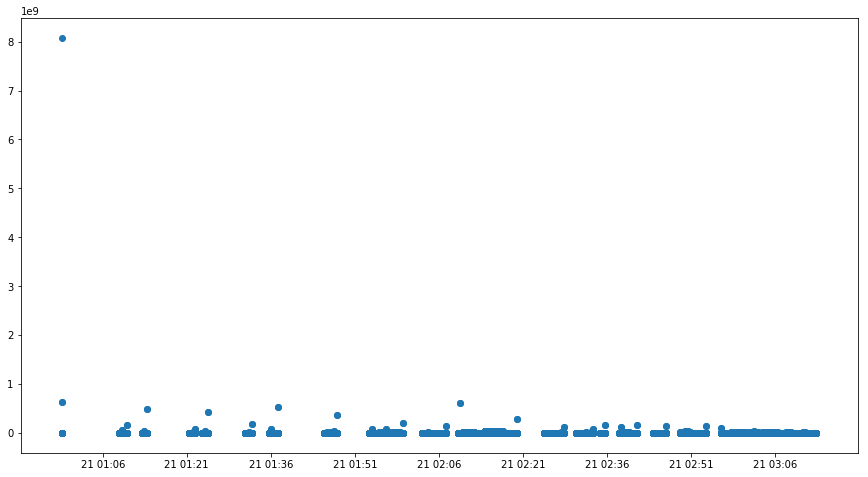

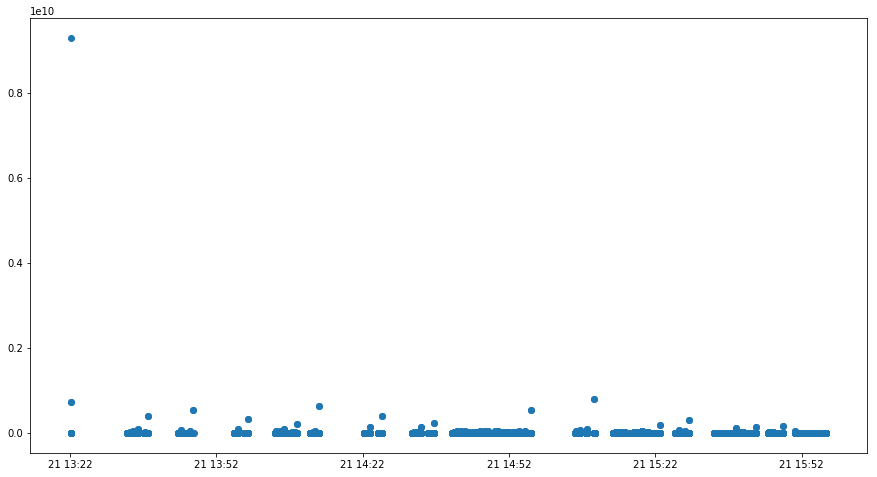

In [194]:
a = get_processes_job_filter(jobid=j)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
#plt.gcf().autofmt_xdate()
plt.show()

a = get_processes_job_filter(jobid=jlong)    
#print(a)
e,t,d = zip(*a)
plt.plot([],[])
plt.scatter(t,d)
#plt.gcf().autofmt_xdate()
plt.show()






Let's examine metrics of interest

In [ ]:
tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","time_waiting","systemtime", "rdtsc_duration" ]

# This function gets all metrics and Thread(primary key) in all input JIDS that match EXE
# Input: list of JIDS and exename
# Output: DataFrame with 'thread' and N columns of metrics

def get_df_all_process(jids,exe):
    q = Process.select(lambda p: p.job in jids and p.exename==exe).without_distinct()
#    print "exe",exe,"ran",len(q),"times"
    q = select(p.threads.metrics for p in q).without_distinct()
# order by is important as it always produces the same order of threads
    q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# make lists
    meas = {}
    for m in q[:]:
        if m[1] not in meas:
            meas[m[1]] = [ (m[0], m[2]) ]
        else:
            meas[m[1]].append( (m[0], m[2]) )
# make df
    df = pd.DataFrame()
    for k in tofind:
        if k in meas:
            v,t = zip(*meas[k])
            df[k] = v
            if 'thread' not in df.columns:
                df['thread'] = t
    return df

# This function develops filtering/outlier criteria from a set of jobs, by executable
# Input: List of JIDS
# Output: Dictionary by exe of statistical data for each metric (mean/stddev/etc)

def get_filter_criteria(by_jids):
# First compute averages of filter/reference jobs
    q1 = Process.select(lambda p: p.job in by_jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(by_jids,exe)
        print(exe,"found",len(df),"times")
        criteria[exe] = df.describe()
#        outlier_dfs=[]
#        outlier_procs=[]
#        for metric in tofind:
            #       print len(df[metric])
#            b = get_outliers_by_quantile(df[['thread',metric]].copy(),metric)
            #       print len(b)
            #print_outliers(b,metric)
#            outlier_dfs.append(b)
#            for index, row in b.iterrows():
#                outlier_procs.append(row['thread'].process)
        #print "Processes with more than one outlier"
        #procs,metrics = zip(*outlier_procs)
#        procs = outlier_procs
#        dfvc = pd.DataFrame({'thread': procs})
#        vc = dfvc['thread'].value_counts()
#        vc = vc[ vc != 1]
#        for index, value in vc.iteritems():
#            print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
#        if len(vc):
#            vc.plot.bar(subplots=True,title=index.exename+" processes with > 1 outlier",color=['darkblue'])
#            plt.show()
# FIX:      We should record which outlier(s) for each process!
#            pass
#        newdf = df
#        for d in outlier_dfs:
#            newdf = remove_outliers(newdf,d)
#        print df.describe()
    return criteria
#
# If we get here, we now have, by executable, a set of criteria to filter the input jobs
#
# Criteria is a dict [exe][metric]["std" or "dev"]
# Should be an object with a method

def filter_jobs(jids,exe_criteria,zscore_threshold=3.0):
    q1 = Process.select(lambda p: p.job in jids).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    criteria = {}
    for exe in q1[:]:
        df = get_df_all_process(jids,exe)
        print(exe,"found",len(df),"times")
        # create dataframe for zscores for this exe, all metrics
        zscores = pd.DataFrame(columns=tofind)
#        zscores['thread'] = df['thread']
        # for each column/metric
        for column in df:
            if column == 'thread':
                continue
            metric = column
            if metric not in tofind:
                continue
            if exe not in exe_criteria:
                continue
            mean = exe_criteria[exe][metric]["mean"]
            std = exe_criteria[exe][metric]["std"]
            if mean == 0 and (std == 0 or std == pd.np.nan):
#                print metric,exe,"mean is 0 or std is 0/Nan, skipping"
                zscores[metric] = pd.Series(False, index=df.index)
                continue
#            print "checking",len(df),exe,"metric",metric,"against mean",mean,"stddev",std
# Z-score (X-mu)/sigma
            zscores[column] = (abs(df[column] - mean)/std > zscore_threshold)
# Does any row have a True?    
        zs = zscores.any(axis='columns')
# Which ones?
        indices = zs[zs == False].index
# Drop non-outliers
        df.drop(indices, inplace=True)
        zscores.drop(indices,inplace=True)
        print("*** ",exe,"has",len(df),len(zscores),"with outliers ***")
#        for index, row in df.iterrows():
#            print(row)
#            print(zscores.loc[index, :])

    return False, False

#criteria = get_filter_criteria([js[0]])        
#outliers, outlier_metrics = filter_jobs([js[0]],criteria)
#print(outlier_metrics)



In [198]:
# 
# Lets snarf up a few jobs of atmos_level and use them to filter the last one
#
ref_jobs=[]
js = get_job_list()
for j in js:
    if j.ppr and j.ppr.component == "atmos_level":
        print(j.jobid,"("+j.ppr.component+")","from",j.start,"by",j.user.name,"took",j.duration/1e6,"s.")
        ref_jobs.append(j)

# Last 1
to_analyze_jobs = ref_jobs[4:]
# First 4
ref_jobs = ref_jobs[:4]

20345340.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-20 19:58:41.714446 by Jeffrey.Durachta took 7618.369066 s.
20348694.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 04:41:56.596528 by Jeffrey.Durachta took 8948.181983 s.
20349537.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 08:22:12.046131 by Jeffrey.Durachta took 8227.289876 s.
20352721.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-21 15:12:27.619713 by Jeffrey.Durachta took 4826.598722 s.
20362929.moab01.princeton.rdhpcs.noaa.gov (atmos_level) from 2019-02-22 15:00:09.280291 by Jeffrey.Durachta took 8548.81482 s.


In [ ]:
criteria = get_filter_criteria(ref_jobs)
print("mean,stddev,COV of criterion for outlier detection")
for e in sorted(criteria):
    print(e)
    for m in criteria[e]:
        lms = criteria[e].loc['mean',m]
        lmsd = criteria[e].loc['std',m]
        print("\t",m,lms,lmsd,lmsd/lms)


arch found 1410 times
basename found 108 times
bash found 3626 times
cat found 154 times
chmod found 660 times
cp found 249 times
cut found 19373 times


In [ ]:
# Filter our jobs by the criteria
# Return values not yet supported
filter_jobs(to_analyze_jobs,criteria)
#print outlier_metrics

In [ ]:
# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="globus-url-copy").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )

# Very important to be sorted by thread object here!

df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

# TEST
#t = Thread[41211]
#print t,t.process
#print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

outlier_dfs=[]
outlier_procs=[]
for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    outlier_dfs.append(b)
    for index, row in b.iterrows():
            outlier_procs.append(row['thread'].process) 

#print outliers
print("Processes with more than one outlier")
dfvc = pd.DataFrame({'thread': outlier_procs})
vc = dfvc['thread'].value_counts()
vc = vc[ vc != 1]
#badboys = pd.DataFrame(columns=["key","exe","host","time","duration_us"])
for index, value in vc.iteritems():
        print(index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration)
ax = vc.plot.bar(title="Processes with more than one outlier",color=['darkblue'])


newdf = df
for d in outlier_dfs:
    newdf = remove_outliers(newdf,d)

print(df.describe())
print(newdf.describe())

In [ ]:


#df = pd.DataFrame({'Duration': q[:]})
#print df.describe()
#array = [durs]
#plt.boxplot(array,showmeans=True,whis=99)
#plt.show()




In [ ]:

# Returns rows of dataframe where metric value is bigger than quantile
def get_outliers_by_quantile(pdf, metric, quantile_to_return=.999):
    cutoff = pdf[metric].quantile(q=quantile_to_return)
    return pdf[pdf[metric] > cutoff]

def print_outliers(d, metric):
    if len(d.index):
        print("\t",len(d.index),"outliers in metric",metric,"mean",d[metric].describe()["mean"]) 
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print("\t",thr,proc,proc.exename+"("+str(proc.pid)+") at",proc.start,metric,row[metric])
        
def remove_outliers(dfi, dfol):
    dfi = dfi[~dfi.thread.isin(dfol.thread)]
    return dfi
